In [1]:
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain_ollama import ChatOllama
from langchain_huggingface import HuggingFaceEmbeddings  # HuggingFace嵌入

load_dotenv()

model = ChatOpenAI(
                    temperature=0,
                    max_tokens=4096,
                    presence_penalty=1.2,
                    # model='deepseek-chat',
                    # openai_api_key=os.getenv('DEEPSEEK_API_KEY'),
                    # openai_api_base="https://api.deepseek.com/v1",
                    model='gpt-4o-mini',
                    openai_api_key=os.getenv('CLOSEAI_API_KEY'),
                    openai_api_base="https://api.openai-proxy.org/v1",
                )

# model = ChatOllama(
#                     temperature=0,
#                     num_predict=4096,
#                     repeat_penalty=1.2,
#                     model="llama3.2:3b"
#                 )

embedding = HuggingFaceEmbeddings(
            model_name="../../Embedding/maidalun/bce-embedding-base_v1",
            model_kwargs={"device": "cuda",
                          "trust_remote_code": True},
            encode_kwargs={"normalize_embeddings": True},
        )

c:\Users\farben\anaconda3\envs\lclg\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Build the agent

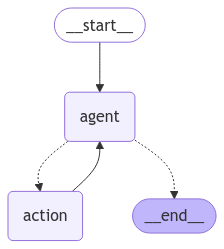

In [6]:
from typing import Literal

from langchain_core.tools import tool

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.prebuilt import ToolNode

memory = MemorySaver()


@tool
def search(query: str):
    """Call to surf the web."""
    # This is a placeholder for the actual implementation
    # Don't let the LLM know this though 😊
    return "It's sunny in San Francisco, but you better look out if you're a Gemini 😈."


tools = [search]
tool_node = ToolNode(tools)
bound_model = model.bind_tools(tools)


def should_continue(state: MessagesState):
    """Return the next node to execute."""
    last_message = state["messages"][-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return END
    # Otherwise if there is, we continue
    return "action"


# Define the function that calls the model
def call_model(state: MessagesState):
    response = model.invoke(state["messages"])
    # We return a list, because this will get added to the existing list
    return {"messages": response}


# Define a new graph
workflow = StateGraph(MessagesState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("action", tool_node)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.add_edge(START, "agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    # Next, we pass in the path map - all the possible nodes this edge could go to
    ["action", END],
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("action", "agent")

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile(checkpointer=memory)
app

In [4]:
from langchain_core.messages import HumanMessage

config = {"configurable": {"thread_id": "2"}}

input_message = HumanMessage(content="hi! I'm bob")
for event in app.stream({"messages": [input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()


input_message = HumanMessage(content="what's my name?")
for event in app.stream({"messages": [input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

hi! I'm bob
================================== Ai Message ==================================

Hi Bob! How can I assist you today?
================================ Human Message =================================

what's my name?
================================== Ai Message ==================================

Your name is Bob! How can I help you today?


In [8]:
app.invoke({"messages": [input_message]}, config, stream_mode="values")

{'messages': [HumanMessage(content="what's my name?", additional_kwargs={}, response_metadata={}, id='fe874275-df3b-4da2-8646-f120e8900779'),
  AIMessage(content="I'm sorry, but I don't have access to personal information about users unless it has been shared with me in the course of our conversation. If you'd like, you can tell me your name!", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 38, 'prompt_tokens': 12, 'total_tokens': 50, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_39a40c96a0', 'finish_reason': 'stop', 'logprobs': None}, id='run-0a50e0ea-207c-41e4-a66a-d74d286c8aeb-0', usage_metadata={'input_tokens': 12, 'output_tokens': 38, 'total_tokens': 50, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'outpu

# Manually deleting messages

In [9]:
messages = app.get_state(config).values["messages"]
messages

[HumanMessage(content="what's my name?", additional_kwargs={}, response_metadata={}, id='fe874275-df3b-4da2-8646-f120e8900779'),
 AIMessage(content="I'm sorry, but I don't have access to personal information about users unless it has been shared with me in the course of our conversation. If you'd like, you can tell me your name!", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 38, 'prompt_tokens': 12, 'total_tokens': 50, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_39a40c96a0', 'finish_reason': 'stop', 'logprobs': None}, id='run-0a50e0ea-207c-41e4-a66a-d74d286c8aeb-0', usage_metadata={'input_tokens': 12, 'output_tokens': 38, 'total_tokens': 50, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_detail

In [10]:
from langchain_core.messages import RemoveMessage

app.update_state(config, {"messages": RemoveMessage(id=messages[0].id)})

{'configurable': {'thread_id': '2',
  'checkpoint_ns': '',
  'checkpoint_id': '1efbd239-75ac-6b4b-8002-7b697b55b5b0'}}

In [11]:
messages = app.get_state(config).values["messages"]
messages

[AIMessage(content="I'm sorry, but I don't have access to personal information about users unless it has been shared with me in the course of our conversation. If you'd like, you can tell me your name!", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 38, 'prompt_tokens': 12, 'total_tokens': 50, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_39a40c96a0', 'finish_reason': 'stop', 'logprobs': None}, id='run-0a50e0ea-207c-41e4-a66a-d74d286c8aeb-0', usage_metadata={'input_tokens': 12, 'output_tokens': 38, 'total_tokens': 50, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]

# Programmatically deleting messages

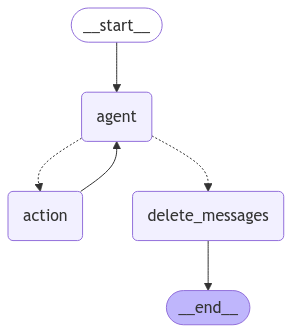

In [12]:
from langchain_core.messages import RemoveMessage
from langgraph.graph import END


def delete_messages(state):
    messages = state["messages"]
    if len(messages) > 3:
        return {"messages": [RemoveMessage(id=m.id) for m in messages[:-3]]}


# We need to modify the logic to call delete_messages rather than end right away
def should_continue(state: MessagesState) -> Literal["action", "delete_messages"]:
    """Return the next node to execute."""
    last_message = state["messages"][-1]
    # If there is no function call, then we call our delete_messages function
    if not last_message.tool_calls:
        return "delete_messages"
    # Otherwise if there is, we continue
    return "action"


# Define a new graph
workflow = StateGraph(MessagesState)
workflow.add_node("agent", call_model)
workflow.add_node("action", tool_node)

# This is our new node we're defining
workflow.add_node(delete_messages)


workflow.add_edge(START, "agent")
workflow.add_conditional_edges(
    "agent",
    should_continue,
)
workflow.add_edge("action", "agent")

# This is the new edge we're adding: after we delete messages, we finish
workflow.add_edge("delete_messages", END)
app = workflow.compile(checkpointer=memory)
app

In [13]:
from langchain_core.messages import HumanMessage

config = {"configurable": {"thread_id": "3"}}

input_message = HumanMessage(content="hi! I'm bob")
for event in app.stream({"messages": [input_message]}, config, stream_mode="values"):
    print([(message.type, message.content) for message in event["messages"]])


input_message = HumanMessage(content="what's my name?")
for event in app.stream({"messages": [input_message]}, config, stream_mode="values"):
    print([(message.type, message.content) for message in event["messages"]])

[('human', "hi! I'm bob")]
[('human', "hi! I'm bob"), ('ai', 'Hi Bob! How can I assist you today?')]
[('human', "hi! I'm bob"), ('ai', 'Hi Bob! How can I assist you today?'), ('human', "what's my name?")]
[('human', "hi! I'm bob"), ('ai', 'Hi Bob! How can I assist you today?'), ('human', "what's my name?"), ('ai', 'Your name is Bob! How can I help you today?')]
[('ai', 'Hi Bob! How can I assist you today?'), ('human', "what's my name?"), ('ai', 'Your name is Bob! How can I help you today?')]


In [14]:
messages = app.get_state(config).values["messages"]
messages

[AIMessage(content='Hi Bob! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 11, 'total_tokens': 21, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_6fc10e10eb', 'finish_reason': 'stop', 'logprobs': None}, id='run-7c487108-e2d9-4587-bfd9-19b88b059fba-0', usage_metadata={'input_tokens': 11, 'output_tokens': 10, 'total_tokens': 21, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
 HumanMessage(content="what's my name?", additional_kwargs={}, response_metadata={}, id='6ed6db89-af60-4194-8cec-d80105f5748c'),
 AIMessage(content='Your name is Bob! How can I help you today?', additional_kwargs={'refusal': None}, respons